In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/BERT

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/BERT


In [ ]:
# Load Dataset
true_data = pd.read_csv('true2.csv')
fake_data = pd.read_csv('fake2.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data,fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,"Kid Rock Just Had His First Political Rally, ...","Robert Ritchie, AKA Kid Rock, has shown quite ...",News,"September 14, 2017",Fake
1,5-YR OLD CHRISTIAN GIRL Forced To Live With No...,A white five-year-old girl told her mother Chr...,left-news,"Aug 28, 2017",Fake
2,LISTEN UP! CHAIRMAN FOR TEENS FOR TRUMP Sends ...,CJ Pierson is such a great kid! he s sending m...,politics,"Aug 13, 2016",Fake
3,Soccer star Weah leads most counties in Liberi...,MONROVIA (Reuters) - Former soccer star George...,worldnews,"October 12, 2017",True
4,House Speaker Ryan urges coordinated response ...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"March 22, 2016",True


In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame containing the 'Target' column
data['label'] = (data['Target'] == 'Fake').astype(int)


In [ ]:
data.head()

,title,text,subject,date,Target,label
0,"Kid Rock Just Had His First Political Rally, ...","Robert Ritchie, AKA Kid Rock, has shown quite ...",News,"September 14, 2017",Fake,1
1,5-YR OLD CHRISTIAN GIRL Forced To Live With No...,A white five-year-old girl told her mother Chr...,left-news,"Aug 28, 2017",Fake,1
2,LISTEN UP! CHAIRMAN FOR TEENS FOR TRUMP Sends ...,CJ Pierson is such a great kid! he s sending m...,politics,"Aug 13, 2016",Fake,1
3,Soccer star Weah leads most counties in Liberi...,MONROVIA (Reuters) - Former soccer star George...,worldnews,"October 12, 2017",True,0
4,House Speaker Ryan urges coordinated response ...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"March 22, 2016",True,0


([<matplotlib.patches.Wedge at 0x7a0057f81300>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

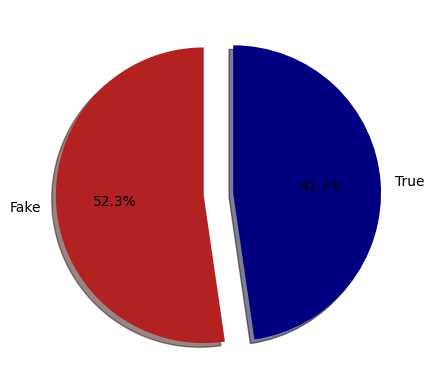

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
from transformers import AutoModel, AutoTokenizer
roberta = AutoModel.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text(0, 0.5, 'Number of texts')

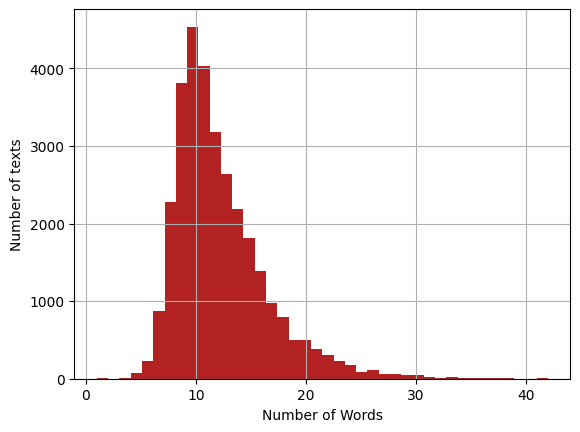

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using RoBERTa."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)
# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[0, 36590, 4486, 340, 1421, 4, 2], [0, 36949, 3830, 11126, 38495, 4, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [ ]:
# Freezing the parameters
for param in roberta.parameters():
    param.requires_grad = False


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
from transformers import AdamW

# Load RoBERTa model and tokenizer
roberta = AutoModel.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

class RoBERTa_Arch(nn.Module):
    def __init__(self, roberta):
        super(RoBERTa_Arch, self).__init__()
        self.roberta = roberta
        self.dropout = nn.Dropout(0.1)            # dropout layer
        self.relu =  nn.ReLU()                    # relu activation function
        self.fc1 = nn.Linear(768, 512)            # dense layer 1
        self.fc2 = nn.Linear(512, 2)              # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_hs = output['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)                           # output layer
        x = self.softmax(x)                       # apply softmax activation
        return x

model = RoBERTa_Arch(roberta)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function
cross_entropy = nn.NLLLoss()

# Number of training epochs
epochs = 3


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

def train(train_dataloader, model, optimizer, cross_entropy):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]  # push the batch to device
        sent_id, mask, labels = batch
        optimizer.zero_grad()  # clear previously calculated gradients
        preds = model(sent_id, mask)  # get model predictions for current batch
        loss = cross_entropy(preds, labels)  # compute loss between actual & predicted values
        total_loss += loss.item()  # add on to the total loss
        loss.backward()  # backward pass to calculate the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip gradients to 1.0
        optimizer.step()  # update parameters

    avg_loss = total_loss / len(train_dataloader)  # compute training loss of the epoch
    return avg_loss


def evaluate(val_dataloader, model, cross_entropy):
    print("\nEvaluating...")
    model.eval()  # Deactivate dropout layers
    total_loss = 0
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]  # Push the batch to device
        sent_id, mask, labels = batch
        with torch.no_grad():  # Deactivate autograd
            preds = model(sent_id, mask)  # Model predictions
            loss = cross_entropy(preds, labels)  # Compute the validation loss
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)  # compute the validation loss of the epoch
    return avg_loss


In [ ]:
device = torch.device('cpu')

# Inside train and evaluate functions, remove .to(device) from batch assignments

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train(train_dataloader, model, optimizer, cross_entropy)  # train model
    valid_loss = evaluate(val_dataloader, model, cross_entropy)  # evaluate model
    if valid_loss < best_valid_loss:  # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'roberta_new_model_weights.pt')
    train_losses.append(train_loss)  # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.030
Validation Loss: 0.005

 Epoch 2 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])